In [1]:
#import modules
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
# common model helpers
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Configure inline and set style
%matplotlib inline
sns.set()

In [2]:
#import raw
train_raw = pd.read_csv('../train.csv')
test_raw = pd.read_csv('../test.csv')
#make copy for wrangling
train1 = train_raw.copy(deep=True)
#put in one wrangling_set to wrangle both at once
wr_set = [train1, test_raw]

In [3]:
print(train_raw.info())
train_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


891 entries except for Age, Cabin, and Embarked.

In [4]:
#How many missing values
print('Training Set nulls\n', train1.isnull().sum())
print('Testing Set nulls\n', test_raw.isnull().sum())

Training Set nulls
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Testing Set nulls
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [5]:
train1.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Jarvis, Mr. John Denzil",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Deal with missing values

In [6]:
#Age- use median
# Embarked- use mode
# Fare- use median

for givenset in wr_set:
    givenset['Age'].fillna(value=givenset['Age'].median(), inplace=True)
    givenset['Embarked'].fillna(value=givenset['Embarked'].mode()[0], inplace=True)
    givenset['Fare'].fillna(value=givenset['Fare'].median(), inplace=True)
#Drop  PassengerId, Cabin, Ticket    
dropcols = ['PassengerId', 'Cabin', 'Ticket']
train1.drop(dropcols, axis=1, inplace=True)

In [7]:
print('Training Set nulls\n', train1.isnull().sum())
print('Testing Set nulls\n', test_raw.isnull().sum())

Training Set nulls
 Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
Testing Set nulls
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


Bin Fare, Age.
Calculate family size

In [8]:
for givenset in wr_set:
    #FamilySize
    givenset['FamilySize'] = givenset['Parch']+givenset['SibSp']+1
    givenset.drop(['Parch','SibSp'], axis=1, inplace=True)
    #AgeBin
    givenset['AgeBin'] = pd.qcut(givenset['Age'], 4, labels=False)
    givenset.drop('Age', axis=1, inplace=True)
    #FareBin
    givenset['FareBin'] = pd.qcut(givenset['Fare'], 4, labels=False)
    givenset.drop('Fare', axis=1, inplace=True)   
    # Create Title feature
    givenset['Title'] = givenset['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [9]:
# Replace wrong designations
train1['Title'] = train1['Title'].replace({'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle':'Miss'})

# Group uncommon designations as misc
stat_min = 10
title_names = train1['Title'].value_counts() < stat_min

train1['Title'] = train1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(train1['Title'].value_counts())

Mr        517
Miss      185
Mrs       126
Master     40
Misc       23
Name: Title, dtype: int64


In [10]:
train1.head()

,Survived,Pclass,Name,Sex,Embarked,FamilySize,AgeBin,FareBin,Title
0,0,3,"Braund, Mr. Owen Harris",male,S,2,0,0,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,C,2,3,3,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,S,1,1,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,S,2,2,3,Mrs
4,0,3,"Allen, Mr. William Henry",male,S,1,2,1,Mr


In [11]:
# code categorical data
label = LabelEncoder()

for dataset in wr_set:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
# define y variable for target/outcome
Target = ['Survived']

# define x variable for original features aka feature selection
train1_x = ['Sex', 'Pclass', 'Embarked', 'Title', 'FamilySize']

# pretty name/values for charts
train1_x_calc = ['Sex', 'Pclass', 'Embarked_Code', 'Title_Code', 'SibSp', 'Parch', 'Age', 'Fare'] # coded for algo calc

train1_xy = Target + train1_x
print('Original X Y: ',train1_xy,'\n' )


# define x variables for original with bin features. Categorical coded numerically instead of in words.
train1_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
train1_xy_bin = Target + train1_x_bin
print('Bin X Y: ', train1_xy_bin, '\n')


# Establish dummy variables
train1_dummy = pd.get_dummies(train1[train1_x])
train1_x_dummy = train1_dummy.columns.tolist()
train1_xy_dummy = Target + train1_x_dummy
print('Dummy X Y: ', train1_xy_dummy, '\n')

train1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'FamilySize'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'FamilySize', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,FamilySize,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,2,0,1,0,0,1,0,0,0,1,0
1,1,2,1,0,1,0,0,0,0,0,0,1
2,3,1,1,0,0,0,1,0,0,1,0,0
3,1,2,1,0,0,0,1,0,0,0,0,1
4,3,1,0,1,0,0,1,0,0,0,1,0


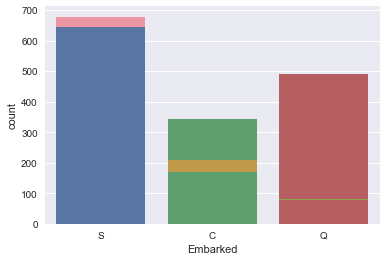

In [29]:

sns.countplot(x=att, data=train1);
    
    #sns.factorplot(x='Survived', col=attribute, kind='count', data=train1);
#     train1.groupby(['Sex']).Survived.sum()
    

In [ ]:
sns.countplot(x='Survived', data=train1);

In [ ]:
sns.countplot(x='Sex', data=train1);

In [ ]:
sns.factorplot(x='Survived', col='Sex', kind='count', data=train1);

In [ ]:
train1.groupby(['Sex']).Survived.sum()

In [ ]:
sns.countplot(x='Embarked', data=train1);

In [ ]:
sns.factorplot(x='Survived', col='Embarked', kind='count', data=train1);

In [4]:
train1.groupby(['Embarked']).Survived.sum()

Embarked
C     93
Q     30
S    217
Name: Survived, dtype: int64

In [5]:
print('C: ', train1[train1.Embarked == 'C'].Survived.sum()/train1[train1.Embarked == 'C'].Survived.count())
print('Q: ', train1[train1.Embarked == 'Q'].Survived.sum()/train1[train1.Embarked == 'Q'].Survived.count())
print('S: ', train1[train1.Embarked == 'S'].Survived.sum()/train1[train1.Embarked == 'S'].Survived.count())

C:  0.5535714285714286
Q:  0.38961038961038963
S:  0.33695652173913043


To do: age, fare, cabin, embarked all contain null values.

Age- use median

Embarked- use mode

Fare- use median

Cabin- drop altogether

In [6]:
for givenset in wr_set:
    givenset['Age'].fillna(value=givenset['Age'].median(), inplace=True)
    givenset['Embarked'].fillna(value=givenset['Embarked'].mode()[0], inplace=True)
    givenset['Fare'].fillna(value=givenset['Fare'].median(), inplace=True)
    
dropcols = ['PassengerId', 'Cabin', 'Ticket']
train1.drop(dropcols, axis=1, inplace=True)

In [7]:

print('Training Set nulls\n', train1.isnull().sum())

print(test_raw.isnull().sum())

Training Set nulls
 Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


Create new data cols:

FamilySize = Parch + Sibsp + 1

IsAlone = 1 if alone, else 0 if FamilySize > 1

Title: 1 if titled, 0 if not

FareBin: 4 bins

AgeBin: 5 bins

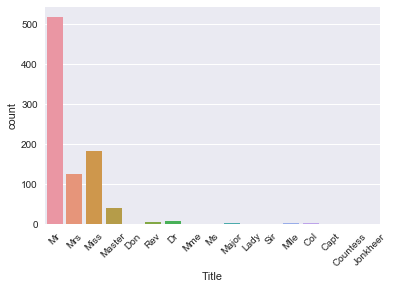

In [8]:
train1['Title'] = train1.Name.apply(lambda x: re.search('([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=train1);
plt.xticks(rotation=45);

In [9]:
for givenset in wr_set:
    #FamilySize
    givenset['FamilySize'] = givenset['Parch']+givenset['SibSp']+1
    #IsAlone
    givenset['IsAlone'] = 1
    givenset['IsAlone'].loc[givenset['FamilySize'] > 1] =0
    #Title
    givenset['AgeBin'] = givenset['Name'].str.split(', ', )
    

C:\Users\Morgan\AppData\Local\Programs\Python\Python36\Lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
